In [29]:
import pandas as pd
import numpy as np
#import knn_impute as knn_impute
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.linear_model import LogisticRegression as LR
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn.tree import export_graphviz

import profit_curve_plot as pcp


import warnings

import matplotlib.pyplot as plt 
%matplotlib inline

## Team:

#### Doster
#### Amelia
#### Kevin

## Data: 

#### Ride Sharing Churn

we are attempting to predict if a rider with churn (not have used the service in the last 30 days).

## EDA and Cleaning

In [30]:
main_df = pd.read_csv('data/churn_train.csv')


In [31]:
main_df.head()


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,6.94,5.0,5.0,1.00,Astapor,2014-05-03,Android,2014-01-12,0.0,0,False,100.0
1,8.06,5.0,5.0,1.00,Astapor,2014-01-26,Android,2014-01-25,0.0,2,True,0.0
2,21.50,4.0,NaN,1.00,Winterfell,2014-05-21,iPhone,2014-01-02,0.0,1,True,100.0
3,9.46,5.0,NaN,2.75,Winterfell,2014-01-10,Android,2014-01-09,100.0,1,False,100.0
4,13.77,5.0,NaN,1.00,Winterfell,2014-05-13,iPhone,2014-01-31,0.0,0,False,100.0


In [32]:
main_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 12 columns):
avg_dist                  40000 non-null float64
avg_rating_by_driver      39838 non-null float64
avg_rating_of_driver      33472 non-null float64
avg_surge                 40000 non-null float64
city                      40000 non-null object
last_trip_date            40000 non-null object
phone                     39681 non-null object
signup_date               40000 non-null object
surge_pct                 40000 non-null float64
trips_in_first_30_days    40000 non-null int64
luxury_car_user           40000 non-null bool
weekday_pct               40000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 3.4+ MB


In [33]:
main_df.describe()


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,40000.000000,39838.000000,33472.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,5.791302,4.777434,4.601697,1.074956,8.857342,2.280700,60.874382
std,5.708056,0.448088,0.614810,0.222427,20.014008,3.811289,37.089619
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.930000,5.000000,5.000000,1.050000,8.300000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


In [34]:
def create_churn(last_trip_column):
    '''1 is churn, 0 is not churn'''
    return (last_trip_column < pd.to_datetime('06/01/2014')).astype(int)

def column_convert_date(df):
    '''automatically tries to select columns that looks like dates and converts them'''
    df = df.apply(lambda col: pd.to_datetime(col, errors='ignore')
          if col.dtypes == object
          else col,
          axis=0)
    return df

def add_date_columns(df, column_name=None, date_desc=None):
    if column_name is None or len(column_name) == 0:
        column_name = df_num.select_dtypes(include=[np.datetime64]).columns
    if data_desc is None or len(data_desc)==0:
        data_desc = ['year','month','day','dayofweek','weekday_name','hour','time','minute']
    for dt_type in date_desc:
        df[column_name + '_' + dt_type] = pd.DatetimeIndex(df[column_name]).year

    if 1 ==2:
        df[column_name + '_year'] = pd.DatetimeIndex(df[column_name]).year
        df[column_name + '_month'] = pd.DatetimeIndex(df[column_name]).month
        df[column_name + '_day'] = pd.DatetimeIndex(df[column_name]).day
        df[column_name + '_hour'] = pd.DatetimeIndex(df[column_name]).hour
        df[column_name + '_dayofweek'] = pd.DatetimeIndex(df[column_name]).dayofweek
        df[column_name + '_weekday'] = pd.DatetimeIndex(df[column_name]).weekday_name
        df[column_name + '_time'] = pd.DatetimeIndex(df[column_name]).time
        df[column_name + '_minute'] = pd.DatetimeIndex(df[column_name]).minute
    return df

def create_days_since_activation(sign_up_column):
    return (pd.to_datetime('06/30/2014') - sign_up_column).dt.days

In [35]:
def clean_data(main_df):
    main_df = column_convert_date(main_df)
    y = create_churn(main_df['last_trip_date'])
    main_df = main_df.drop(['last_trip_date'], axis = 1)
#     main_df['phone'] = knn_impute.knn_impute(main_df['phone'], main_df.drop(['phone', 'avg_rating_by_driver', 'avg_rating_of_driver'], axis = 1), k_neighbors = 5, aggregation_method = 'mode')
#     main_df['avg_rating_by_driver'] = knn_impute.knn_impute(main_df['phone'], main_df.drop(['phone', 'avg_rating_by_driver', 'avg_rating_of_driver'], axis = 1), k_neighbors = 5)
#     main_df['avg_rating_of_driver'] = knn_impute.knn_impute(main_df['phone'], main_df.drop(['phone', 'avg_rating_by_driver', 'avg_rating_of_driver'], axis = 1), k_neighbors = 5)
    main_df['phone'] = main_df['phone'].fillna('undefined')
    main_df['avg_rating_by_driver'] = main_df['avg_rating_by_driver'].fillna(np.mean(main_df['avg_rating_by_driver']))
    main_df['avg_rating_of_driver'] = main_df['avg_rating_of_driver'].fillna(np.mean(main_df['avg_rating_of_driver']))
    main_df['days_since_active'] = create_days_since_activation(main_df['signup_date'])
    main_df = main_df.drop(['signup_date'], axis = 1)
    main_df = pd.get_dummies(main_df)
    return y, main_df

def clean_test(main_df):
    y, x = clean_data(main_df)
    columns_to_standardize = ['days_since_active', 'weekday_pct', 'trips_in_first_30_days', 'surge_pct', 'avg_surge', 'avg_rating_of_driver', 'avg_rating_by_driver', 'avg_dist']
    standard = StandardScaler()
    standard.fit(x[columns_to_standardize])
    x[columns_to_standardize] = standard.transform(x[columns_to_standardize])
    return x, y

We changed the last_trip_date column into a churn column based on if it was in the last month.
We changed catagorical variables to dummies and the sign_up date to days_since_activation.

In [36]:
y, x = clean_data(main_df)
#print(x.head())
y.describe()
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 15 columns):
avg_dist                  40000 non-null float64
avg_rating_by_driver      40000 non-null float64
avg_rating_of_driver      40000 non-null float64
avg_surge                 40000 non-null float64
surge_pct                 40000 non-null float64
trips_in_first_30_days    40000 non-null int64
luxury_car_user           40000 non-null bool
weekday_pct               40000 non-null float64
days_since_active         40000 non-null int64
city_Astapor              40000 non-null uint8
city_King's Landing       40000 non-null uint8
city_Winterfell           40000 non-null uint8
phone_Android             40000 non-null uint8
phone_iPhone              40000 non-null uint8
phone_undefined           40000 non-null uint8
dtypes: bool(1), float64(6), int64(2), uint8(6)
memory usage: 2.7 MB


We then did a train test split and standardized our numeric values

In [92]:
X_train, X_test, y_train, y_test = train_test_split(x,y)

columns_to_standardize = ['days_since_active', 'weekday_pct', 'trips_in_first_30_days', 'surge_pct', 'avg_surge', 'avg_rating_of_driver', 'avg_rating_by_driver', 'avg_dist']
standard = StandardScaler()
standard.fit(X_train[columns_to_standardize])
X_train[columns_to_standardize] = standard.transform(X_train[columns_to_standardize])
X_test[columns_to_standardize] = standard.transform(X_test[columns_to_standardize])
print(y_train.describe());

/home/amelia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/amelia/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/amelia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.p

count    30000.000000
mean         0.623133
std          0.484609
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: last_trip_date, dtype: float64


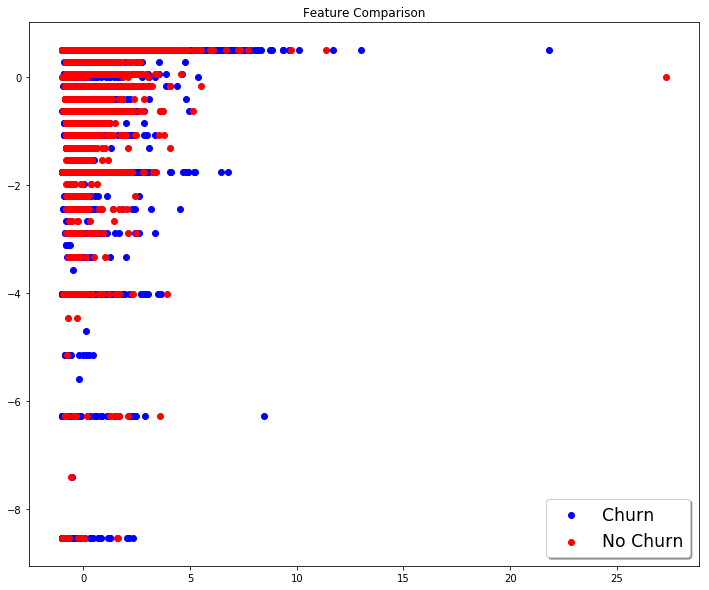

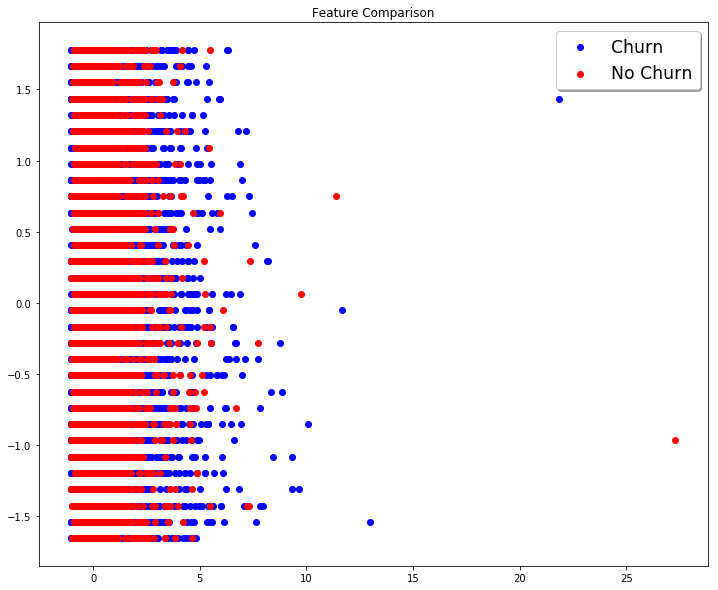

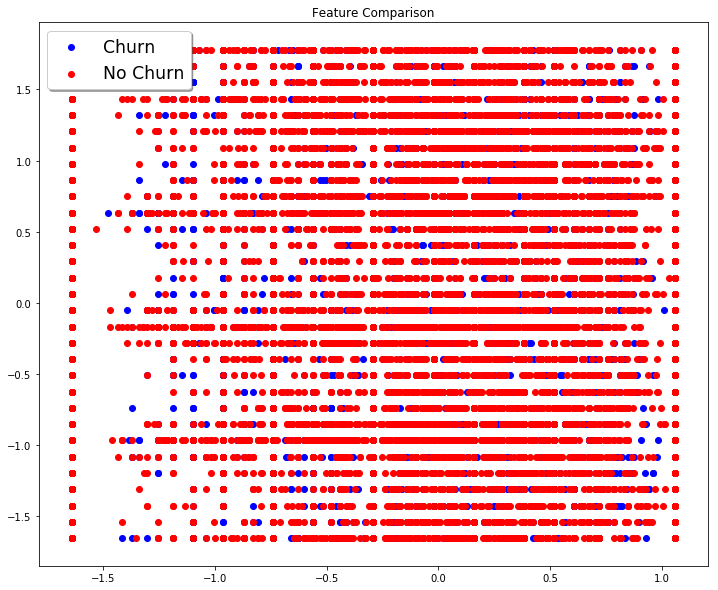

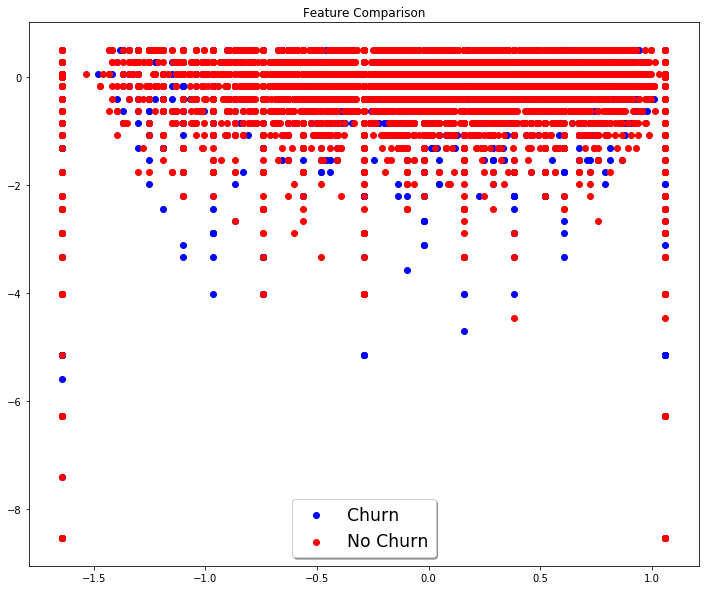

In [88]:
def plot_feature_pairs(df_churn, df_no_churn, feature1, feature2):    

    fig = plt.figure(figsize=(12,10))

    ax = fig.add_subplot(111)

    ax.scatter(df_churn[feature1], df_churn[feature2], color='b', label='Churn')

    ax.scatter(df_no_churn[feature1], df_no_churn[feature2], color='r', label='No Churn')

    ax.legend(shadow=True, fontsize='xx-large')


    ax.set_title('Feature Comparison')

    plt.show()
    
temp_x = X_train.copy()
temp_x['label'] = y_train
df_churn = temp_x[temp_x['label'] == 1]
df_no_churn = temp_x[temp_x['label'] == 0]
plot_feature_pairs(df_churn, df_no_churn, 'avg_dist', 'avg_rating_by_driver')

plot_feature_pairs(df_churn, df_no_churn, 'avg_dist', 'days_since_active')

plot_feature_pairs(df_churn, df_no_churn, 'weekday_pct', 'days_since_active')

plot_feature_pairs(df_churn, df_no_churn, 'weekday_pct', 'avg_rating_by_driver')

## Models

In [10]:
def logistic_reg(X_train, y_train, X_test, y_test):
    log = LogisticRegression(penalty='l1')
    log.fit(X_train, y_train)
    y_predict_log = log.predict(X_test)
    log_precision = precision_score(y_test, y_predict_log)
    cv_precision = cross_val_score(log, X_train, y_train, scoring='precision')
    return log_precision, np.mean(cv_precision), confusion_matrix(y_test, y_predict_log) 


def basic_tree(x_train, y_train, x_test, y_test):
    param_grid = {'max_depth': np.arange(3, 10)}
    tree_model = GridSearchCV(DecisionTreeClassifier(), param_grid)
    #tree_model = DecisionTreeClassifier()
    tree_model.fit(x_train, y_train)
    y_predict = tree_model.predict(x_test)
    print(tree_model.best_params_)
    print(precision_score(y_test, y_predict))
    
def ran_forest(x_train, y_train, x_test, y_test):
    param_grid = {
    'n_estimators': [700, 850, 1000],
    'max_features': ['auto']}
    ran_forest_model = GridSearchCV(RandomForestClassifier(), param_grid)
    ran_forest_model.fit(x_train, y_train)
    y_predict = ran_forest_model.predict(x_test)
    print(ran_forest_model.best_params_)
    print(precision_score(y_test, y_predict))
    
def boost_forest(x_train, y_train, x_test, y_test):
    param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "n_estimators": [700, 850, 10000]}
    boost_forest_model = GridSearchCV(AdaBoostClassifier(DecisionTreeClassifier(max_depth=3)), param_grid)
    boost_forest_model.fit(x_train.values, y_train.values)
    y_predict = boost_forest_model.predict(x_test)
    print(boost_forest_model.best_params_)
    print(precision_score(y_test, y_predict))
    
def svc_model(X_train, y_train):
    clf = SVC(kernel='rbf', gamma=1, C=1)
    clf.fit(X_train, y_train)
    return clf

In [11]:
#basic_tree(X_train, y_train, X_test, y_test)
#ran_forest(X_train, y_train, X_test, y_test)
#boost_forest(X_train, y_train, X_test, y_test)

### Precision Scores
Tree:
0.79

Random Forest:
0.80

Boosted:
0.80

Logistic:
0.74

KNN:
.811

SVC: 
.77

In [44]:
tree_model = DecisionTreeClassifier(max_depth=8)
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [23]:
knc = KNeighborsClassifier(n_neighbors=5,n_jobs=-1)
knc.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform')

In [ ]:
random_forest_model = RandomForestClassifier(max_features= 'auto', n_estimators= 850)
random_forest_model.fit(X_train, y_train)
# boost_model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), base_estimator= 'gini',  n_estimators= 700)
# boost_model.fit(X_train, y_train)  
svc_model = svc_model(X_train, y_train)

In [82]:
def feature_importance(model, x_test, y_test):
    columns=['avg_dist', 'avg_rating_by_driver','avg_rating_of_driver', 'avg_surge', 'surge_pct', 'trips_in_first_30_days', 'luxury_car_user', 'weekday_pct', 'days_since_active', 'city_Astapor',"city_King's Landing", 'city_Winterfell','phone_Android', 'phone_iPhone',  'phone_undefined']
    original_precision = precision_score(y_test, model.predict(x_test))
    test_precisions = []
    col_prec_dict = {}
    col_std_dict = {}
    for column_ind in range(x_test.shape[1]):
        test_precisions = []
        x_temp = x_test.copy()
        for num in range(100):
            indexes = np.random.permutation(np.arange(x_test.shape[0]))
            column = x_temp[:,column_ind]
            x_temp[ : ,column_ind] = column[indexes]
            test_precisions.append(precision_score(y_test, model.predict(x_temp)))
        col_prec_dict[columns[column_ind]] = original_precision-np.mean(test_precisions)
        col_std_dict[columns[column_ind]] = np.std(test_precisions)
    return col_prec_dict, col_std_dict

In [83]:
column_importance_dict, column_std_dict = feature_importance(tree_model, np.array(X_test), np.array(y_test))

In [84]:
print(column_importance_dict)
print(column_std_dict)

{'avg_dist': 0.0019034259383546859, 'avg_rating_by_driver': 0.049877448522211321, 'avg_rating_of_driver': 0.00037133835015812355, 'avg_surge': 0.001548896177305914, 'surge_pct': 0.013997118853968038, 'trips_in_first_30_days': 0.0076489203106248072, 'luxury_car_user': 0.01357202800371482, 'weekday_pct': 0.026749921455620052, 'days_since_active': 0.00058804790881328284, 'city_Astapor': 0.0044753929977398021, "city_King's Landing": 0.036502756230942235, 'city_Winterfell': -8.3390357153323436e-05, 'phone_Android': 0.017859497359442478, 'phone_iPhone': 0.0092485303277497488, 'phone_undefined': 4.5995112044616704e-06}
{'avg_dist': 0.00085132538604405198, 'avg_rating_by_driver': 0.0021031899516391543, 'avg_rating_of_driver': 0.00035846594067127609, 'avg_surge': 0.00079418286122113124, 'surge_pct': 0.0016825900925002675, 'trips_in_first_30_days': 0.0010402637836838401, 'luxury_car_user': 0.0017587183018581026, 'weekday_pct': 0.0014589541640000606, 'days_since_active': 0.00026093956458311687, '

### Change in Precision Per Feature

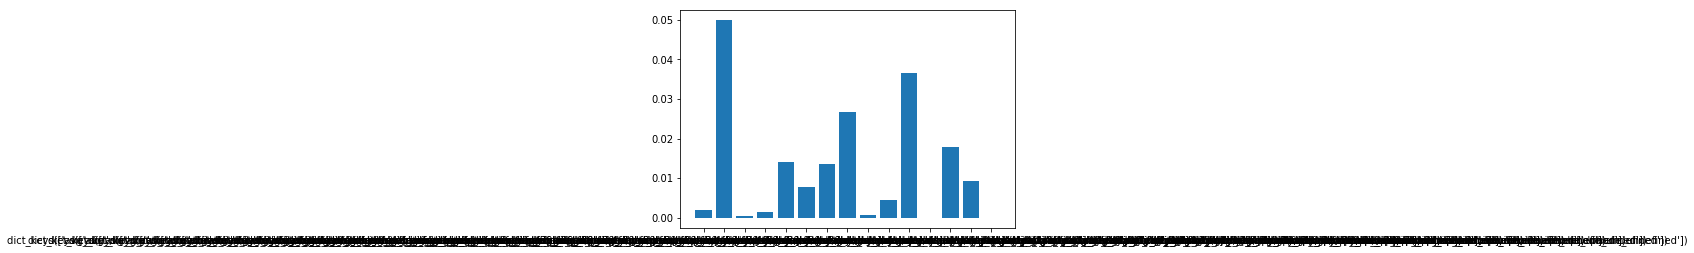

In [89]:

plt.bar(range(len(column_importance_dict)),column_importance_dict.values(),tick_label=column_importance_dict.keys());


### Variance in Precision Per Feature when Feature Values Randomized

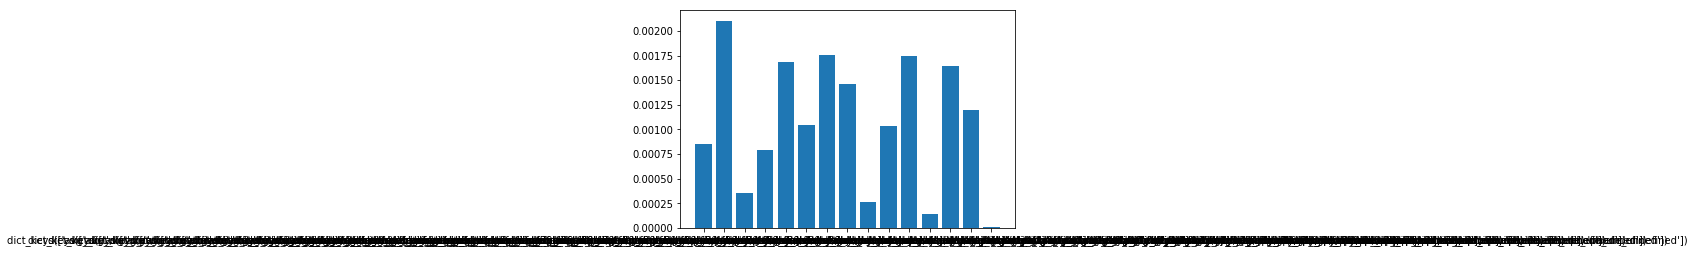

In [90]:
plt.bar(range(len(column_std_dict)),column_std_dict.values(),tick_label=column_std_dict.keys());

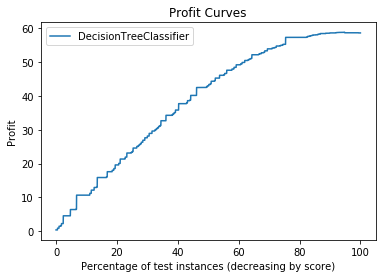

Best model:		DecisionTreeClassifier
Best threshold:		0.07
Resulting profit:	58.73
Proportion positives:	0.88


In [43]:
cost_benefit = np.array([[100, -10], [ 0,   0]])

#add fitted models here
fitted_models = [knc, tree_model]

pcp.profit_curve_main(fitted_models, X_train, X_test, y_train, y_test, cost_benefit)

## Testing With Unseen Data

0.792885137172


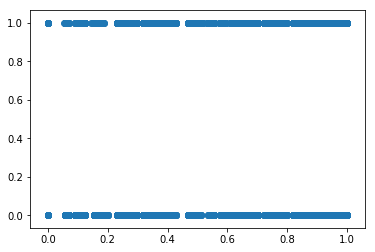

In [19]:
main_df = pd.read_csv('data/churn_test.csv')
x_unseen, y_unseen = clean_test(main_df)
y_predicted = tree_model.predict(x_unseen)
print(precision_score(y_unseen, y_predicted))
export_graphviz(tree_model, out_file='tree.dot')
pred_prob = tree_model.predict_proba(x_unseen)[:,1]
plt.scatter(pred_prob, y_unseen)


In [22]:
features_import = tree_model.feature_importances_
columns=['avg_dist', 'avg_rating_by_driver','avg_rating_of_driver', 'avg_surge', 'surge_pct', 'trips_in_first_30_days', 'luxury_car_user', 'weekday_pct', 'days_since_active', 'city_Astapor',"city_King's Landing", 'city_Winterfell','phone_Android', 'phone_iPhone',  'phone_undefined']
for column in range(len(columns)):
    print(f'{columns[column]}:      {features_import[column]}')

avg_dist: 0.02120570302271651
avg_rating_by_driver: 0.3990698455134217
avg_rating_of_driver: 0.011513082822400612
avg_surge: 0.017891358724398333
surge_pct: 0.03847691192052352
trips_in_first_30_days: 0.04053794438787525
luxury_car_user: 0.06104359710602371
weekday_pct: 0.11207078679020566
days_since_active: 0.007571029014710216
city_Astapor: 0.005714373722620238
city_King's Landing: 0.18147367149323274
city_Winterfell: 0.007554782420128268
phone_Android: 0.05830270988086035
phone_iPhone: 0.03757420318088278
phone_undefined: 0.0


In [42]:
model = LR(penalty='l1')
model.fit(X_train, y_train)
coeff = pd.DataFrame(model.coef_,columns=X_train.columns)

coeff

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,days_since_active,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,phone_undefined
0,0.205858,0.080685,0.033949,0.056191,-0.089235,-0.446934,-0.86917,0.016363,-0.043436,0.999188,-0.73655,0.465858,1.075283,-0.029645,0.680981


### What is important for churn?
#### Importance across multiple models using feature importance on trees and coefficients of logistic regression

Distance Travelled:            20% coefficient, 20% importance

Avg rating by driver:           7%              17%

Days since active              -5%              13%

Avg rating of driver:           4%               4%


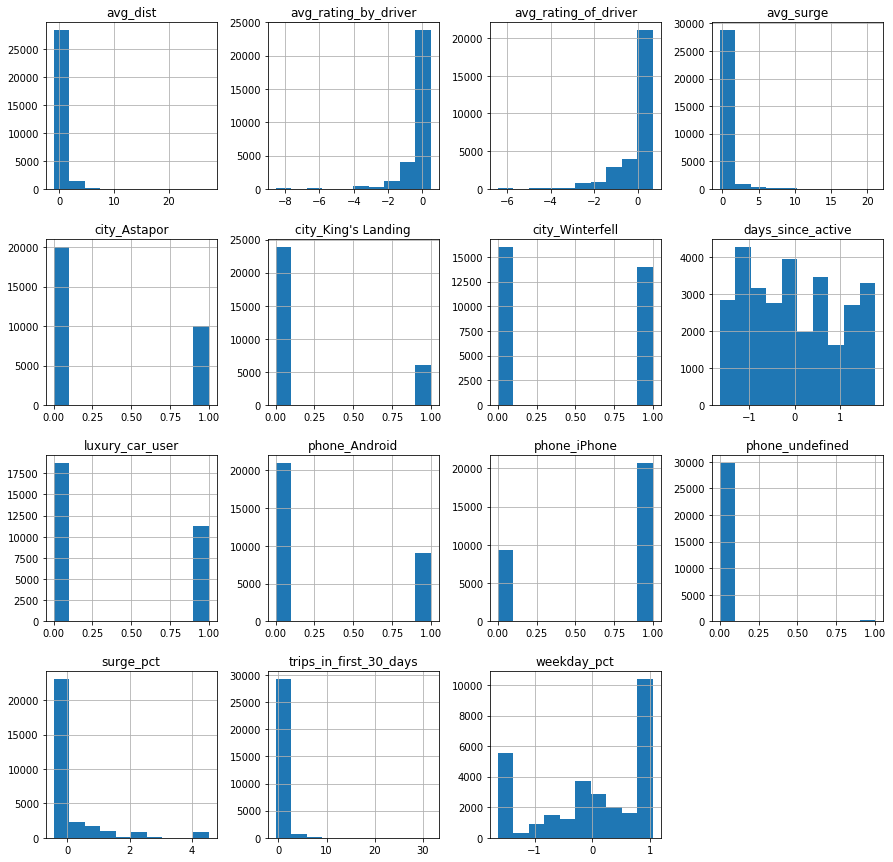

In [52]:
X_train.hist(figsize=(15,15));

### Recommendations

Discount users that are likely to churn AND are traveling longer than average distances

Incentivize users and drives to actively rate their experience